## Введение
Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

### Задача:

1. Проверить Был ли эксперимент успешен в целом.

2. Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.*


## Данные 

### users_*.csv – информация о пользователях

uid – идентификатор пользователя

age – возраст

attraction_coeff – коэффициент привлекательности (от 0 до 1000, лайки/просмотры *1000)

coins – число монеток (внутренняя валюта)

country – страна  

visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)

gender – пол

age_filter_start  – фильтр поиска, мин. значение 

age_filter_end  – фильтр поиска, макс. значение 

views_count – число полученных оценок 

was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)

is_premium –  является ли премиум

total_revenue – нормированная выручка


### transactions_*.csv – информация о платежах пользователей:

uid – идентификатор пользователя

country – страна

joined_at – дата и время регистрации

paid_at – дата и время покупки

revenue – нормированная выручка

payment_id – идентификатор платежа

from_page – откуда пользователь перешел на страницу оплаты

product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за 
внутреннюю валюту, other_type – другое)


### Файлы:

users_test – информация о пользователях в тестовой группе. 

users_control_1 – информация о пользователях в первой контрольной группе. 

users_control_2 – информация о пользователях во второй контрольной группе . 

transactions_test – информация о платежах пользователей в тестовой группе. 

transactions_control_1 – информация о платежах пользователей в первой контрольной группе. 

transactions_control_2 – информация о платежах пользователей во второй контрольной группе 
  



In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import datetime

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import norm, mannwhitneyuъ
from scipy import stats

# Преобразуем данные

In [115]:
def processing_a_data(df):
   df.fillna('0', inplace=True)
   df['visit_days'] = df['visit_days'].apply (lambda x : [int(i) for i in x.replace('.',',').split(',') ] )
   df['count_of_visit_days'] = df['visit_days'].apply (lambda x : len(x) if x[0]!=0 else 0)
   df[['was_premium','is_premium','coins']] = df[['was_premium','is_premium','coins']].astype(int)
   lst_col = ['uid', 'age', 'attraction_coeff', 'coins', 'country', 'visit_days', 'count_of_visit_days',
   'gender', 'age_filter_start', 'age_filter_end', 'views_count',
   'was_premium', 'is_premium', 'total_revenue']
   return df[lst_col] 




In [117]:
users_test = pd.read_csv('./users_test.csv',sep = ';') 
users_test = processing_a_data(users_test)
users_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   uid                  4308 non-null   int64 
 1   age                  4308 non-null   int64 
 2   attraction_coeff     4308 non-null   int64 
 3   coins                4308 non-null   int64 
 4   country              4308 non-null   object
 5   visit_days           4308 non-null   object
 6   count_of_visit_days  4308 non-null   int64 
 7   gender               4308 non-null   int64 
 8   age_filter_start     4308 non-null   int64 
 9   age_filter_end       4308 non-null   int64 
 10  views_count          4308 non-null   int64 
 11  was_premium          4308 non-null   int64 
 12  is_premium           4308 non-null   int64 
 13  total_revenue        4308 non-null   int64 
dtypes: int64(12), object(2)
memory usage: 471.3+ KB


In [112]:
users_control_1 = pd.read_csv('./users_control_1.csv', sep = ';')
users_control_1 = processing_a_data(users_control_1)
users_control_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   uid                  4340 non-null   int64 
 1   age                  4340 non-null   int64 
 2   attraction_coeff     4340 non-null   int64 
 3   coins                4340 non-null   object
 4   country              4340 non-null   object
 5   visit_days           4340 non-null   object
 6   count_of_visit_days  4340 non-null   int64 
 7   gender               4340 non-null   int64 
 8   age_filter_start     4340 non-null   int64 
 9   age_filter_end       4340 non-null   int64 
 10  views_count          4340 non-null   int64 
 11  was_premium          4340 non-null   int64 
 12  is_premium           4340 non-null   int64 
 13  total_revenue        4340 non-null   int64 
dtypes: int64(11), object(3)
memory usage: 474.8+ KB


In [113]:
users_control_2 = pd.read_csv('./users_control_2.csv', sep = ';')
users_control_2 = processing_a_data(users_control_2)
users_control_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264 entries, 0 to 4263
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   uid                  4264 non-null   int64 
 1   age                  4264 non-null   int64 
 2   attraction_coeff     4264 non-null   int64 
 3   coins                4264 non-null   object
 4   country              4264 non-null   object
 5   visit_days           4264 non-null   object
 6   count_of_visit_days  4264 non-null   int64 
 7   gender               4264 non-null   int64 
 8   age_filter_start     4264 non-null   int64 
 9   age_filter_end       4264 non-null   int64 
 10  views_count          4264 non-null   int64 
 11  was_premium          4264 non-null   int64 
 12  is_premium           4264 non-null   int64 
 13  total_revenue        4264 non-null   int64 
dtypes: int64(11), object(3)
memory usage: 466.5+ KB


In [118]:
transactions_test = pd.read_csv('./transactions_test.csv',sep=';')

transactions_test[['joined_at', 'paid_at']] = transactions_test[['joined_at', 'paid_at']].apply (pd.to_datetime)
transactions_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           273 non-null    int64         
 1   country       273 non-null    object        
 2   joined_at     273 non-null    datetime64[ns]
 3   paid_at       273 non-null    datetime64[ns]
 4   revenue       273 non-null    int64         
 5   payment_id    273 non-null    int64         
 6   from_page     273 non-null    object        
 7   product_type  273 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 17.2+ KB


In [120]:
# Видим,что в данной таблицы много пропущенных значений. Также некоторые столбцы имеют не правельный тип данных.
transactions_control_1 = pd.read_csv('./transactions_control_1.csv', sep=';')
transactions_control_1.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uid           377 non-null    float64
 1   country       377 non-null    object 
 2   joined_at     1007 non-null   object 
 3   paid_at       1007 non-null   object 
 4   revenue       377 non-null    float64
 5   payment_id    377 non-null    float64
 6   from_page     377 non-null    object 
 7   product_type  377 non-null    object 
dtypes: float64(3), object(5)
memory usage: 63.1+ KB


In [121]:
transactions_control_1.dropna(inplace=True)
transactions_control_1[['joined_at', 'paid_at']] = transactions_control_1[['joined_at', 'paid_at']].apply (pd.to_datetime)
transactions_control_1[['uid','revenue','payment_id']] = transactions_control_1[['uid','revenue','payment_id']].astype(int)
transactions_control_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377 entries, 0 to 376
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           377 non-null    int64         
 1   country       377 non-null    object        
 2   joined_at     377 non-null    datetime64[ns]
 3   paid_at       377 non-null    datetime64[ns]
 4   revenue       377 non-null    int64         
 5   payment_id    377 non-null    int64         
 6   from_page     377 non-null    object        
 7   product_type  377 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 26.5+ KB


In [122]:
transactions_control_2 = pd.read_csv('./transactions_control_2.csv',sep=';')
transactions_control_2[['joined_at', 'paid_at']] = transactions_control_2[['joined_at', 'paid_at']].apply (pd.to_datetime)
transactions_control_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           328 non-null    int64         
 1   country       328 non-null    object        
 2   joined_at     328 non-null    datetime64[ns]
 3   paid_at       328 non-null    datetime64[ns]
 4   revenue       328 non-null    int64         
 5   payment_id    328 non-null    int64         
 6   from_page     328 non-null    object        
 7   product_type  328 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 20.6+ KB


In [90]:
df = transactions_test[transactions_test['product_type'] == 'premium_no_trial']
df.groupby(['uid'],as_index=False).agg({'revenue':'count'}).query("revenue > 1")


,uid,revenue
29,891725043,2
33,891861048,2
44,892065108,3
46,892097937,3
54,892261437,2
57,892339626,3


In [89]:
df_1 = transactions_control_1[transactions_control_1['product_type'] == 'premium_no_trial']
df_1.groupby(['uid'],as_index=False).agg({'revenue':'count'}).query("revenue > 1")

,uid,revenue
5,891216033,2
12,891264903,2
51,891822480,2
67,892101909,2
88,892290105,2
94,892366260,2
96,892393119,2


In [88]:
df_2 = transactions_control_2[transactions_control_2['product_type'] == 'premium_no_trial']
df_2.groupby(['uid'],as_index=False).agg({'revenue':'count'}).query("revenue > 1")

,uid,revenue
9,891219540,2
35,891637005,2
78,892139829,3
101,892435536,2


## Проводим А/А тест на двух контрольных данных о транзакциях

  0%|          | 0/10000 [00:00<?, ?it/s]

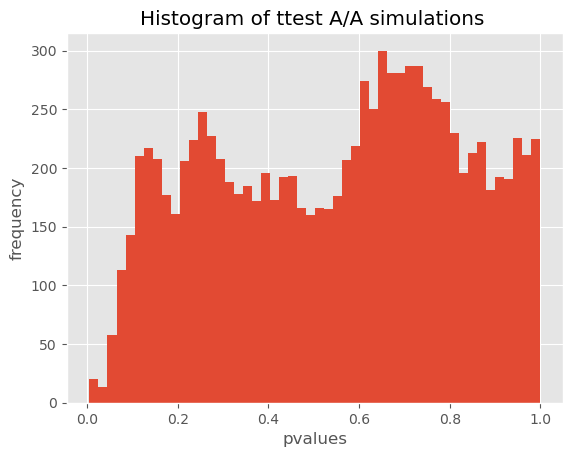

0.004

In [81]:
df_1 = transactions_control_1[transactions_control_1['product_type'] == 'premium_no_trial']
df_2 = transactions_control_2[transactions_control_2['product_type'] == 'premium_no_trial']
n_s = 50
simulations = 10000
res = []


for i in tqdm(range(simulations)):
    s1 = df_1['revenue'].sample(n_s, replace = False).values
    s2 = df_2['revenue'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

В результате делаем вывод, что система сплитования качественная.


In [200]:
# Посмотрим на показатели метрики ARPU в рамках тестируемого продукта (premium_no_trial)
# за общее количество пользователей берем количество уникальных пользователей в группе 

ARPU_test = df.revenue.sum() / users_test.uid.nunique() 

ARPU_control_1 = df_1.revenue.sum() / users_control_1.uid.nunique() 

ARPU_control_2 = df_2.revenue.sum() / users_control_2.uid.nunique() 

print(f'ARPU_test: {ARPU_test}', f'ARPU_control_1: {ARPU_control_1}', f'ARPU_control_2: {ARPU_control_2}', sep='\n')



ARPU_test: 188.186165273909
ARPU_control_1: 179.5527649769585
ARPU_control_2: 174.6737804878049


In [201]:
# Также смотрим на ARPPU 
ARPPU_test = round(df.revenue.sum() / df.uid.nunique(), 2) 

ARPPU_control_1 = round(df_1.revenue.sum() / df_1.uid.nunique(), 2)

ARPPU_control_2 = round(df_2.revenue.sum() / df_2.uid.nunique(), 2 )

print(f'ARPPU_test: {ARPPU_test}', f'ARPPU_control_1: {ARPPU_control_1}', f'ARPPU_control_2: {ARPPU_control_2}', sep='\n')

ARPPU_test: 12100.09
ARPPU_control_1: 7871.3
ARPPU_control_2: 7302.05


In [ ]:
# Можем ещё посмотреть на абсолютную конверсию CR 

In [154]:
df['delta'] = df['paid_at'] - df['joined_at']
list_of_unique_page_df = df.from_page.unique()

/var/folders/98/cq77c4j90csgl9c58kjw89dm0000gn/T/ipykernel_41386/931224934.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta'] = df['paid_at'] - df['joined_at']


In [155]:
df_1['delta'] = df_1['paid_at'] - df_1['joined_at']
list_of_unique_page_df_1 = df_1.from_page.unique()

/var/folders/98/cq77c4j90csgl9c58kjw89dm0000gn/T/ipykernel_41386/4254458593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['delta'] = df_1['paid_at'] - df_1['joined_at']


In [156]:
df_2['delta'] = df_2['paid_at'] - df_2['joined_at']
list_of_unique_page_df_2 = df_2.from_page.unique()

In [157]:
list_of_unique_page_df = list_of_unique_page_df.tolist()
list_of_unique_page_df_1 = list_of_unique_page_df_1.tolist()
list_of_unique_page_df_2 = list_of_unique_page_df_2.tolist()


In [178]:
result = []
for i in list_of_unique_page_df:
    if i not in list_of_unique_page_df_2:
        result.append(i)
result

['delivery_vip']

In [182]:
df[df['from_page']== 'promo_09']

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,delta
12,891178380,Spain,2017-08-11 03:54:00,2017-09-11 21:53:00,113477,147,promo_09,premium_no_trial,31 days 17:59:00
21,891312873,Italy,2017-05-11 21:22:00,2017-10-11 21:51:00,7852,147,promo_09,premium_no_trial,153 days 00:29:00
22,891071157,United States of America,2017-10-11 10:20:00,2017-10-11 16:37:00,9100,147,promo_09,premium_no_trial,0 days 06:17:00
28,892229262,United States of America,2017-10-18 07:20:00,2017-10-19 04:23:00,9100,147,promo_09,premium_no_trial,0 days 21:03:00
74,892205850,Spain,2017-10-18 19:20:00,2017-02-11 00:13:00,5408,147,promo_09,premium_no_trial,-250 days +04:53:00
84,891861489,Australia,2017-10-26 02:31:00,2017-04-11 02:04:00,12597,147,promo_09,premium_no_trial,-199 days +23:33:00
102,892275204,Mexico,2017-10-17 06:09:00,2017-10-17 15:05:00,6214,147,promo_09,premium_no_trial,0 days 08:56:00
129,892217373,United States of America,2017-10-18 14:15:00,2017-10-23 22:45:00,7904,147,promo_09,premium_no_trial,5 days 08:30:00
144,891806436,Italy,2017-10-27 08:51:00,2017-10-30 17:34:00,12597,147,promo_09,premium_no_trial,3 days 08:43:00
197,891603810,United States of America,2017-10-31 06:36:00,2017-04-11 09:25:00,9100,147,promo_09,premium_no_trial,-203 days +02:49:00


In [165]:
list_of_unique_page_df_1

['dating',
 'left_sidebar_menu',
 'promo_09',
 'autoreply_message',
 'none',
 'popular_users_block',
 'no_sympathy',
 'send_message',
 'popular_users_chat',
 'user_profile',
 'fans']